In [1]:
#Import required packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import mylib as my
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay


Things to do:

Explore the data using descriptive statistics and visualizations to understand the data and explore correlations between its features.

Implement validation techniques like K-fold cross-validation

Logistic Regression, Decision Tree, SVM

Evaluate and report on the results of the best models

Organize steps using pipelines.

In [2]:
diabetes_df = pd.read_csv('diabetes.csv')
print(diabetes_df.isna().sum()) #No NaN values
print((diabetes_df == 0).sum()) #Several 0 values, this data is important, fill with the median
#diabetes_df.shape 768 Rows, 9 Columns

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [3]:
columns_replace= ['BloodPressure', 'Glucose', 'SkinThickness', 'Insulin', 'BMI'] #These columns should never have 0 (NULL)

for column in columns_replace :
   me= int(diabetes_df[column].mean(skipna=True))
   diabetes_df[column] = diabetes_df[column].replace(0,me)
print((diabetes_df == 0).sum()) #cleaned up

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [4]:
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,79,33.6,0.627,50,1
1,1,85,66,29,79,26.6,0.351,31,0
2,8,183,64,20,79,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,79,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,20,79,30.1,0.349,47,1


## Data Statistics and Visualizations

## Decision Tree

In [5]:
#Split by features and outcome into arrays

X = diabetes_df.iloc[:, :-1].values
y = diabetes_df.iloc[:, -1].values

In [6]:
#Split data into train/test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [7]:
# K-fold Cross Validation; Searching for best CV value

best_cv = 0
best_mean_accuracy = 0

dt = DecisionTreeClassifier(random_state=22) #Import Classifer 

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(dt, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.6921824104234527
CV: 3, Mean accuracy: 0.6955443966204369
CV: 4, Mean accuracy: 0.7133520074696544
CV: 5, Mean accuracy: 0.7035452485672398
CV: 6, Mean accuracy: 0.7328669331810395
CV: 7, Mean accuracy: 0.7312658605762055
CV: 8, Mean accuracy: 0.7181946343130554
CV: 9, Mean accuracy: 0.6938050582551861
CV: 10, Mean accuracy: 0.7250132205182445
Best CV value: 6 with mean accuracy: 0.7328669331810395


In [8]:
#Using Randomized Grid Search to tune hyperparameters

parameters = {
    'max_depth': range(1, 16), 
    'max_features': range(1, 6), 
    'max_leaf_nodes': range(2, 50),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': range(2, 11)
}
dt = DecisionTreeClassifier(random_state=11) #Import Classifer 
gs = RandomizedSearchCV(dt, parameters, cv=best_cv) #Randomized search
gs.fit(X_train, y_train)

/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=6, estimator=DecisionTreeClassifier(random_state=11),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 16),
                                        'max_features': range(1, 6),
                                        'max_leaf_nodes': range(2, 50),
                                        'min_samples_split': range(2, 11),
                                        'splitter': ['best', 'random']})

In [9]:
gs.best_score_, gs.best_params_

(0.7508249254394315,
 {'splitter': 'best',
  'min_samples_split': 2,
  'max_leaf_nodes': 46,
  'max_features': 4,
  'max_depth': 6,
  'criterion': 'gini'})

Accuracy: 0.7272727272727273


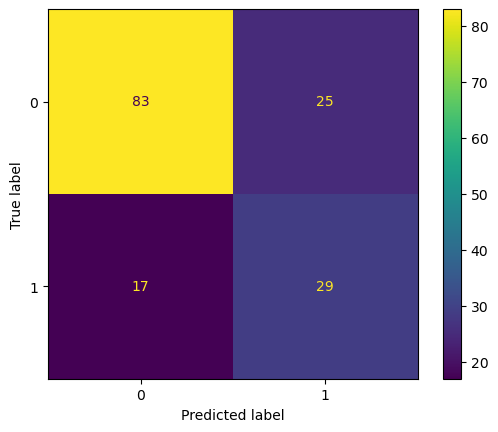

In [10]:
#Training data and plotting confusion matrix

dt = DecisionTreeClassifier(random_state=42, 
                            max_depth=gs.best_params_['max_depth'], 
                            max_features=gs.best_params_['max_features'],
                            max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                            criterion=gs.best_params_['criterion'],
                            splitter=gs.best_params_['splitter'],
                            min_samples_split=gs.best_params_['min_samples_split']) 
dt.fit(X_train, y_train)

my.plot_confusion_matrix_with_accuracy(dt, X_test, y_test)

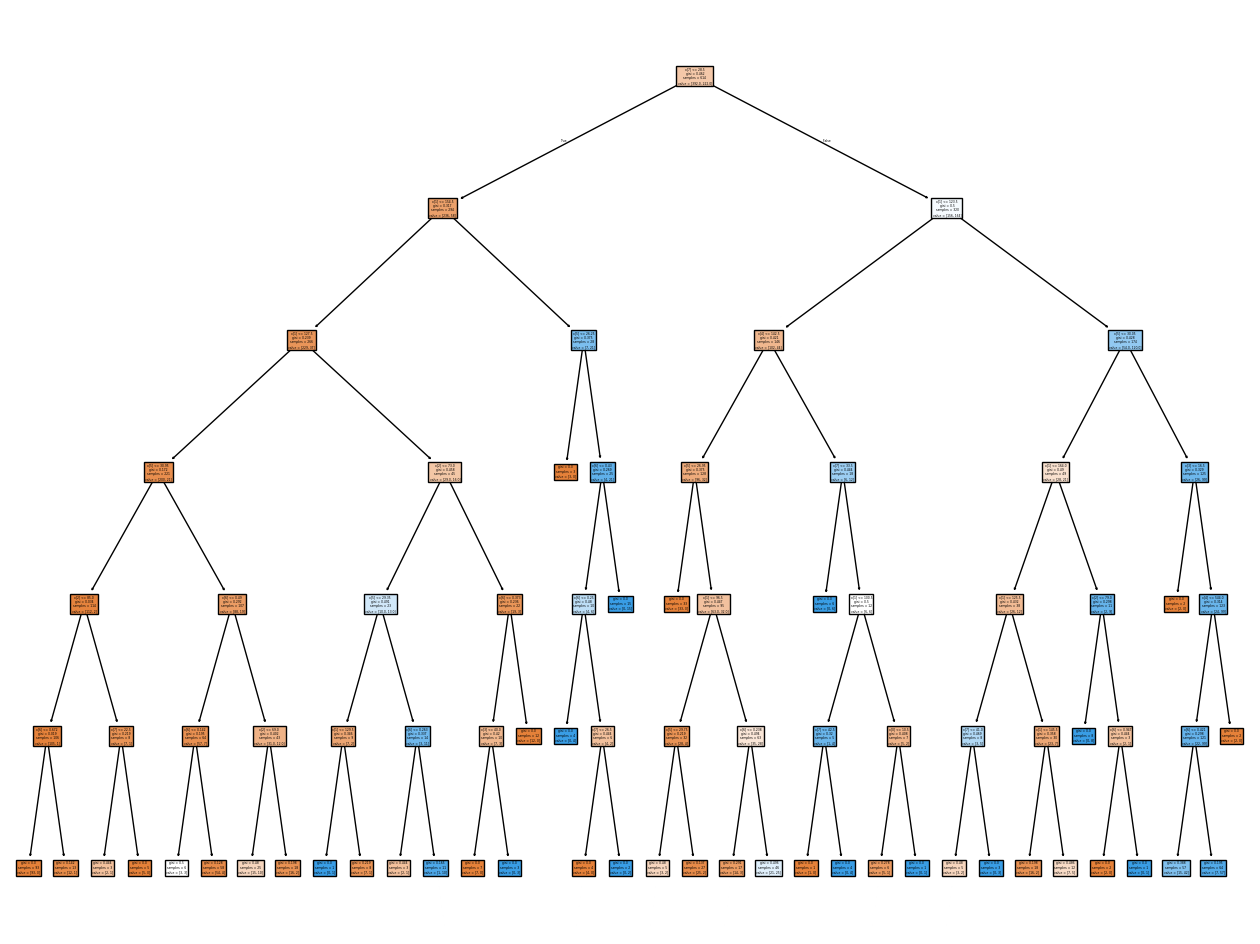

In [11]:
# Plot Decision Tree

fig, ax = plt.subplots(1, 1, figsize=(16,12))
plot_tree(dt, ax=ax, filled=True);

## Logistic Regression


In [12]:
#Split by features and outcome into arrays

X, y = diabetes_df.iloc[:, :-1].values, diabetes_df.iloc[:, -1].values

In [24]:
logreg = LogisticRegression()
logreg.get_params() #Showing hyperparameters

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [22]:
best_cv = 0
best_mean_accuracy = 0

logreg = LogisticRegression(random_state=22, max_iter=1000) #Import Classifer 

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(logreg, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.7785016286644951
CV: 3, Mean accuracy: 0.768683245655986
CV: 4, Mean accuracy: 0.7735867074102368
CV: 5, Mean accuracy: 0.7768359322937491
CV: 6, Mean accuracy: 0.7735738308268291
CV: 7, Mean accuracy: 0.773529631288252
CV: 8, Mean accuracy: 0.7767857142857143
CV: 9, Mean accuracy: 0.775149190110827
CV: 10, Mean accuracy: 0.7751454257006875
Best CV value: 2 with mean accuracy: 0.7785016286644951


In [34]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=11))
pipeline.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(random_state=11))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(random_state=11),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'deprecated',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 11,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [36]:
#Using Randomized Grid Search to tune hyperparameters

parameters = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__max_iter': [100, 200, 500, 1000]
}
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=11))
gs = RandomizedSearchCV(pipeline, parameters, cv=best_cv) #Randomized search
gs.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=11))]),
                   param_distributions={'logisticregression__C': [0.01, 0.1, 1,
                                                                  10, 100],
                                        'logisticregression__max_iter': [100,
                                                                         200,
                                                                         500,
                                                                         1000]})

In [ ]:
gs.best_score_, gs.best_params_

In [ ]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))

In [ ]:
logreg = pipeline(random_state=42, 
                            logisticregression__C=gs.best_params_['logisticregression__C'], 
                            logisticregression__max_iter=gs.best_params_['logisticregression__max_iter']) 
logreg.fit(X_train, y_train)

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [ ]:
#Break: Keep stuff below?

In [37]:
#Make pipeline for scaling and classifier

pipeline = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=42, max_iter=1000))

In [38]:
#Split data into train/test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        92
           1       0.70      0.50      0.58        62

    accuracy                           0.71       154
   macro avg       0.71      0.68      0.68       154
weighted avg       0.71      0.71      0.70       154

Confusion Matrix:


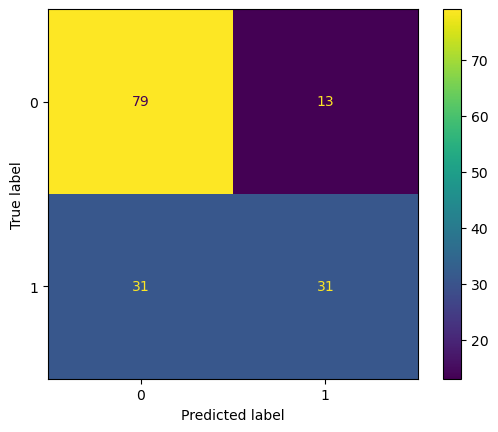

In [40]:
y_pred = pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)


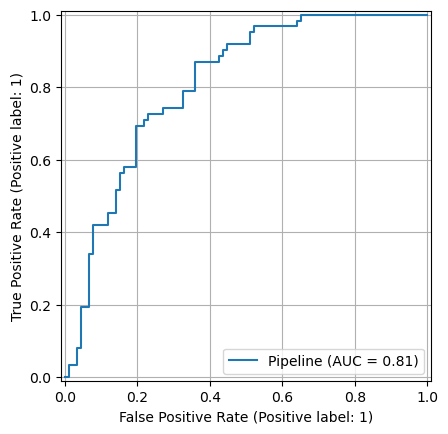

In [41]:
#ROC plot and AUC score to measure performance

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.grid()

/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

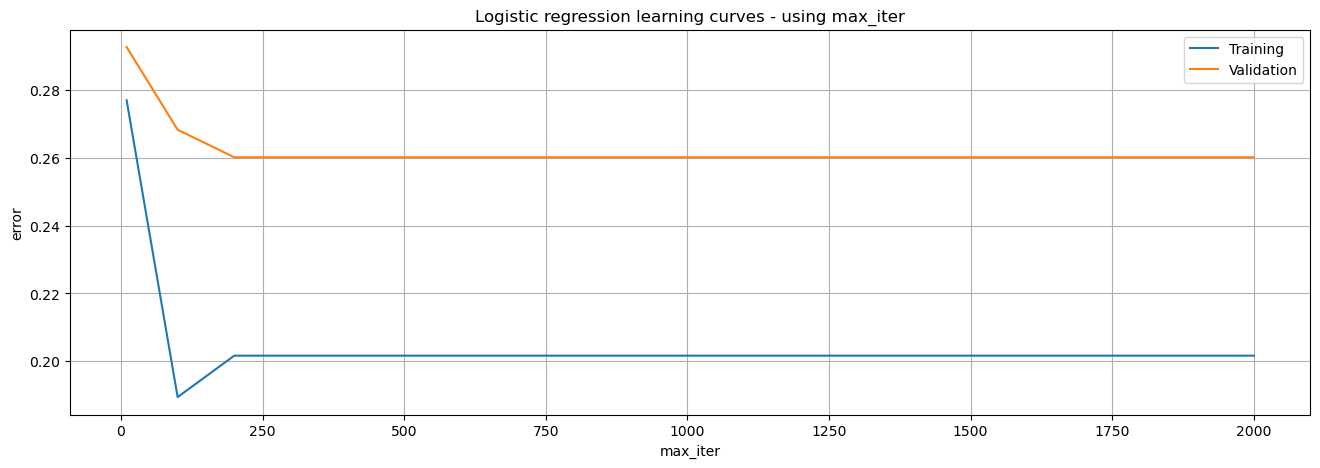

In [42]:
epochs = [10, 100, 200, 300, 400, 500, 700, 900, 1000, 2000]
train_err = []
valid_err = []

# Split the training data further into training and validation sets
X_train_inner, X_valid, y_train_inner, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for n in epochs:
    logr = LogisticRegression(max_iter=n, random_state=42).fit(X_train_inner, y_train_inner)
    
    cm = my.confusion_matrix(y_train_inner, logr.predict(X_train_inner))
    train_err.append(1 - np.trace(cm) / np.sum(cm))

    cm = my.confusion_matrix(y_valid, logr.predict(X_valid))
    valid_err.append(1 - np.trace(cm) / np.sum(cm))
 
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(epochs, train_err, label="Training")
ax.plot(epochs, valid_err, label="Validation")
ax.set_xlabel("max_iter")
ax.set_ylabel("error")
ax.legend()
ax.grid()
ax.set_title("Logistic regression learning curves - using max_iter")
plt.show()

In [43]:
# #Determine good number of epochs

# epochs = [10, 100, 200, 300, 400, 500, 700, 900, 1000, 2000, 3000, 4000, 5000]
# train_err = []
# valid_err = []
# for n in epochs:
#     logr = LogisticRegression(epochs=n).fit(X_train, y_train)
    
#     cm = my.confusion_matrix(y_train, logr.predict(X_train))
#     train_err.append(1 - np.trace(cm) / np.sum(cm))

#     cm = my.confusion_matrix(y_valid, logr.predict(X_valid))
#     valid_err.append(1 - np.trace(cm) / np.sum(cm))
 
# fig = plt.figure(figsize=(16,5))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(epochs, train_err, label="Training")
# ax.plot(epochs, valid_err, label="Validation")
# ax.set_xlabel("epochs")
# ax.set_ylabel("error")
# ax.legend()
# ax.grid()
# ax.set_title("Logistic regression learning curves - using epochs")

## Support Vector Machine (SVM)